In [16]:
pip install git+https://github.com/TigaJi/GeneralBacktest#egg=GeneralBacktest

  Cloning https://github.com/TigaJi/GeneralBacktest to /private/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/pip-install-jfsoowhm/generalbacktest_070621f2e943408a81f4ad050dd527bd
  Running command git clone -q https://github.com/TigaJi/GeneralBacktest /private/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/pip-install-jfsoowhm/generalbacktest_070621f2e943408a81f4ad050dd527bd
  Resolved https://github.com/TigaJi/GeneralBacktest to commit ffaf456219ae29b61cfeb3ab46f72cfe88375645
  Created wheel for GeneralBacktest: filename=GeneralBacktest-0.1-py3-none-any.whl size=6585 sha256=2232ae6db07afce41780cf3e7fea5c79b102cf62023c3fe817cf062394825741
  Stored in directory: /private/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/pip-ephem-wheel-cache-nje78htp/wheels/a3/c4/21/553f7e7356c7617ea7b20d0262f70d14cc427a448cd002b912
Successfully built GeneralBacktest
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
#import Backtest
from GeneralBacktest import Backtest
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import pickle
import yfinance as yf
#warnings.filterwarnings("ignore")

# Bid Class Demo
## intialize a Bid instance with four variables
- ticker
- shares
- price
- bid_type (1 as buy, 0 as sell)


In [2]:
# a bid to buy 100 shares of Apple at $163.43
buy_apple_100 = Bid(ticker = "AAPL", shares = 100, price = 163.43, bid_type = 1)

#the show method could be used for debugging
buy_apple_100.show()

---------------
Buying:
Ticker: AAPL
Shares: 100
Price: 163.43
---------------


# 

# Position class demo
## intialize a Position  instance with a bid instance

In [3]:
apple_position = Position(buy_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 100
Latest_price: 163.43
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	100


## Change the position with another bid

In [4]:
buy_apple_50 = Bid(ticker = "AAPL", shares = 50, price = 163.13, bid_type = 1)
apple_position.change_position(buy_apple_50)
apple_position.show()

Ticker: AAPL
Shares_held: 150
Latest_price: 163.13
weighted_average_cost: 163.33
----------------
Purchasing History
Price	Shares
163.43	100
163.13	50


## Selling a stock

In [5]:
sell_apple_100 = Bid(ticker = 'AAPL', shares = 100, price = 165.24, bid_type = 0)

#if selling a stock, the change_position method will return a cost
#this cost will be the lowest part of costs in purchasing history 
cost_of_buying_100 = apple_position.change_position(sell_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 50
Latest_price: 165.24
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	50


In [6]:
income = sell_apple_100.shares * sell_apple_100.price
print("Income: ", income)
print("Cost: ", cost_of_buying_100)
print("Pnl for this single trade: ", income - cost_of_buying_100 )

Income:  16524.0
Cost:  16328.0
Pnl for this single trade:  196.0


In [7]:
apple_position.change_position(sell_apple_100)

Try to sell 100 shares, but only got 50 shares.


-1

# A demo strategy
## Randomly buy 10 stocks every Monday and sell on Friday
## a strategy is defined as a class, and it must have a predict method that returns a list of Bid instances
## a strategy function has five parameters, which are:
- ti: current datetime 
- df: all historical data up to ti
- positions: a dictionary of all current positions (k: string of ticker, v: an instance of this ticker's Position)
- cash: cash avaliable
- full_data: dataframe with OHLCV

## *This is the part where you implement your strategy

In [4]:
class DemoStrategy:
    def predict(ti,df,positions,cash,full_data):
        bid_list = []

        if ti.weekday() == 0:
            bid = Bid(ticker = 'AAPL', shares = 100, price = df.iloc[-1]['AAPL'],bid_type = 1)

            bid_list.append(bid)
        
        if ti.weekday() == 4:
            bid = Bid(ticker = 'AAPL', shares = 100, price = df.iloc[-1]['AAPL'],bid_type = 0)

            bid_list.append(bid)
        
        return bid_list

# Load sample data

In [5]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

In [6]:
with open("sp100tickers.pickle", "rb") as f:
    tickers = pickle.load(f)
data = get_data(tickers,'5y','1d')

[*********************100%***********************]  100 of 100 completed


# Backtest Demo
## initialize a Backtest instance with data and strategy, in default:
- initial_amount = 100000
- has_tc = True (0.2% of transaction cost)

In [7]:
random_strat = Backtest(data, DemoStrategy)

In [8]:
random_strat.backtest_full()

# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [9]:
random_strat.transaction_history

,dt,ticker,type,price,shares,amount,transaction_cost,pnl
0,2019-03-22,AAPL,0,46.373714,100,4637.371445,0.0,0.000000
1,2019-03-25,AAPL,1,45.813007,100,4581.300735,0.0,0.000000
2,2019-03-29,AAPL,0,46.106716,100,4610.671616,0.0,-4608.000565
3,2019-04-01,AAPL,1,46.419834,100,4641.983414,0.0,0.000000
4,2019-04-05,AAPL,0,47.817959,100,4781.795883,0.0,139.812469
...,...,...,...,...,...,...,...,...
343,2022-09-30,AAPL,0,138.199997,100,13819.999695,0.0,-1257.000732
344,2022-10-03,AAPL,1,142.449997,100,14244.999695,0.0,0.000000
345,2022-10-07,AAPL,0,140.089996,100,14008.999634,0.0,-236.000061
346,2022-10-10,AAPL,1,140.419998,100,14041.999817,0.0,0.000000


In [10]:
print("Total Transaction cost:", random_strat.transaction_history['transaction_cost'].sum())

Total Transaction cost: 0.0


<AxesSubplot:>

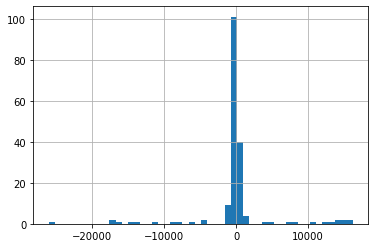

In [11]:
#histogram of pnl
random_strat.transaction_history[random_strat.transaction_history.type ==0]['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions, cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [12]:
random_strat.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-03-20,0,0,100000.000000,0.000000,100000.000000,100000.000000
1,2019-03-21,0,0,100000.000000,0.000000,100000.000000,100954.472279
2,2019-03-22,1,1,95362.628555,4637.371445,100000.000000,99110.450276
3,2019-03-25,1,1,90781.327820,9162.601471,99943.929291,99028.806263
4,2019-03-26,0,1,90781.327820,9067.937469,99849.265289,99948.810466
...,...,...,...,...,...,...,...
893,2022-10-04,0,1,89451.669312,14610.000610,104061.669922,152403.252027
894,2022-10-05,0,1,89451.669312,14639.999390,104091.668701,151698.103828
895,2022-10-06,0,1,89451.669312,14542.999268,103994.668579,149984.872635
896,2022-10-07,1,0,103460.668945,0.000000,103460.668945,145808.889197


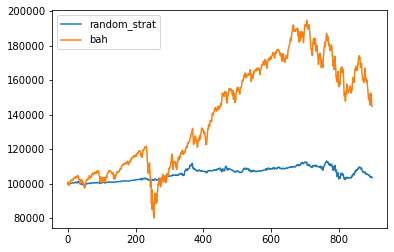

In [13]:
random_strat.plot()

# 

# Upload to dashboard
## the upload_to_dashboard method will upload this graph to dashboard.
## make sure the crediential file "algo-trade-dashboard-80cae071e907.json" is under current directory, also install the related packages in requirements.txt

## to upload, call the function with the strategy name, if the name already exist in the gcloud, the previous data will be overwritten

In [15]:
random_strat.upload_to_dashboard("random_demo_0912")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/